In [65]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt

# Data

In [320]:
df = pd.read_csv('dataset.csv') # ref of generating data: https://cobbl.io/

In [417]:
df['zip'] = df['zip'].astype(str)
df['zip'] = df['zip'].str.rjust(5,'0')
df['gender'] = df['gender'].astype('string')
df['gender'] = df['gender'].replace("Male","0").replace("Female","1")
df['gender'] = df['gender'].astype('int64')

In [360]:
df

,id,first_name,last_name,email,age,gender,zip
0,1,Katherine,Cox,k_m_cox@rocketmail.com,51,1,04266
1,2,Michelle,Bennett,michellemarybennett@yahoo.com,28,1,90254
2,3,Matthew,Ross,m.ross@ymail.com,18,0,24640
3,4,Adam,Baker,a.c@gmail.com,73,0,55760
4,5,Jose,Long,j_g_long90@outlook.com,63,0,42649
...,...,...,...,...,...,...,...
9995,9996,Amelia,Richardson,alrichardson@rocketmail.com,65,1,73443
9996,9997,Victoria,Price,victoria_price7@ymail.com,33,1,37694
9997,9998,Rebecca,Richardson,r.m.richardson@rocketmail.com,66,1,78730
9998,9999,Mateo,Hughes,m_hughes@gmail.com,71,0,82058


# Quasi Identifier

In [418]:
qi = ['gender', 'zip', 'age']

In [419]:
df_qi = pd.DataFrame(df, columns=quasi_identifiers) 

# Create Graph 

In [420]:
def recursive_tree(graph, cur_pos, prev_pos, *args):
    if any(cur > d for cur, d in zip(cur_pos, args)):
        return

    cur = ''.join(map(str, cur_pos))
    prev = ''.join(map(str, prev_pos))

    if cur not in graph:
        graph.add_node(cur)

    if prev != '':
        graph.add_edge(prev, cur)

    for i, d in enumerate(args):
        recursive_tree(graph, tuple(cur_pos[j] + (1 if j == i else 0) for j in range(len(cur_pos))), cur_pos, *args)


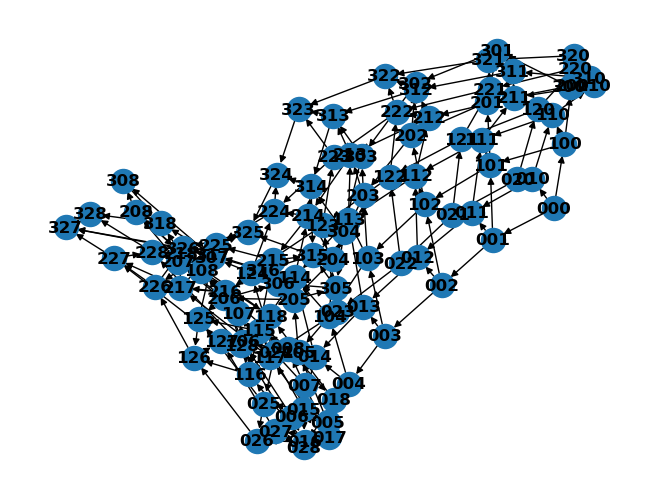

In [437]:
dims = (3, 2, 8)

graph = nx.DiGraph()
recursive_tree(graph, (0,) * len(dims), (), *dims)
nx.draw(graph, with_labels=True, font_weight='bold')
plt.show()

In [438]:
print(graph.nodes)
print(graph.edges)


['000', '100', '200', '300', '310', '320', '321', '322', '323', '324', '325', '326', '327', '328', '311', '312', '313', '314', '315', '316', '317', '318', '301', '302', '303', '304', '305', '306', '307', '308', '210', '220', '221', '222', '223', '224', '225', '226', '227', '228', '211', '212', '213', '214', '215', '216', '217', '218', '201', '202', '203', '204', '205', '206', '207', '208', '110', '120', '121', '122', '123', '124', '125', '126', '127', '128', '111', '112', '113', '114', '115', '116', '117', '118', '101', '102', '103', '104', '105', '106', '107', '108', '010', '020', '021', '022', '023', '024', '025', '026', '027', '028', '011', '012', '013', '014', '015', '016', '017', '018', '001', '002', '003', '004', '005', '006', '007', '008']
[('000', '100'), ('000', '010'), ('000', '001'), ('100', '200'), ('100', '110'), ('100', '101'), ('200', '300'), ('200', '210'), ('200', '201'), ('300', '310'), ('300', '301'), ('310', '320'), ('310', '311'), ('320', '321'), ('321', '322'), ('

In [439]:
generalization_params = {
    'gender': {'type': 'replace', 'dimension': 2},
    'zip': {'type': 'suppression', 'dimension': 3},
    'age': {'type': 'range', 'dimension': 8}
}

replace_values = {
    'gender': 'Person',
    'zip': '',
    'age': ''
}

# Generalize Data

In [459]:
def generalize_data(data, feature, method, dimension, replace_value):
    processed_data = pd.DataFrame(data=data, columns=[feature])
    if int(dimension) < 1:
        return data[feature]

    if method['type'] == 'suppression':
        count = -1
        count = count * int(dimension)
        processed_data = processed_data[feature].map(
            lambda x: str(x)[:count] if len(str(x)[:count]) != 0 else 0
        ).astype(int)
    elif method['type'] == 'range':
        processed_data[feature] = processed_data[feature] // int(dimension) * int(dimension)
        processed_data[feature] = processed_data[feature].astype(str) + '-' + (processed_data[feature] + int(dimension) + 8).astype(str)
    elif method['type'] == 'replace':
        processed_data[feature] = replace_value
        processed_data = processed_data[feature].squeeze()

    return processed_data

# Generate Generalize Dataset

In [449]:
def generate_data_set_for_node(node):
    data_frame = pd.DataFrame(columns=qi)
    index = 0
    for d in str(node):
        feature = qi[index]
        data_frame[feature] = generalize_data(df_qi, feature, generalization_params[feature], d, replace_values[feature])
        index += 1
    return data_frame

# Check K-Anonymous

In [442]:
def is_k_anonymized(data_frame, attributes, k):
    if k > data_frame.shape[0]:
        return False
    grouped = data_frame.groupby(attributes)
    for name, group in grouped:
        if group.shape[0] < k:
            return False
    return True

# Mark all nodes

In [ ]:
def mark_nodes_with_k_attribute(graph, node):
    linked_nodes = list(nx.bfs_tree(graph, source=node).nodes())
    for node in linked_nodes:
        nx.set_node_attributes(graph, {node: {'k': True}})
        graph.nodes[node]['color'] = 'red'
    return graph

# BFS

In [458]:
for node in nx.bfs_tree(graph, source='000').nodes():
    print('--------')
    print('Node: ', node)
    
    n = graph.nodes[node]
    if n.get('k') is not None and n['k']:
        print('Already marked node:', node)
        continue
    
    print('Not marked node:', node)
    
    dataset = generate_data_set_for_node(str(node))
    print(dataset)

    isKAnonymize = isKAnonymized(dataset, qi, k)

    if isKAnonymize:
        print('node', node,' is K-Anonymized', isKAnonymize)
        markNodes(graph, node)
    else:
        print('node', node,' is Not K-Anonymized', isKAnonymize)


--------
Node:  000
Not marked node: 000
      gender    zip  age
0          1  04266   51
1          1  90254   28
2          0  24640   18
3          0  55760   73
4          0  42649   63
...      ...    ...  ...
9995       1  73443   65
9996       1  37694   33
9997       1  78730   66
9998       0  82058   71
9999       1  64441   29

[10000 rows x 3 columns]
No of Rows Grouped: 1
node 000  is Not K-Anonymized False
--------
Node:  100
Not marked node: 100
      gender    zip  age
0     Person  04266   51
1     Person  90254   28
2     Person  24640   18
3     Person  55760   73
4     Person  42649   63
...      ...    ...  ...
9995  Person  73443   65
9996  Person  37694   33
9997  Person  78730   66
9998  Person  82058   71
9999  Person  64441   29

[10000 rows x 3 columns]
No of Rows Grouped: 1
node 100  is Not K-Anonymized False
--------
Node:  010
Not marked node: 010
      gender   zip  age
0          1   426   51
1          1  9025   28
2          0  2464   18
3          0 

No of Rows Grouped: 1
node 310  is Not K-Anonymized False
--------
Node:  301
Not marked node: 301
      gender    zip    age
0     Person  04266  51-60
1     Person  90254  28-37
2     Person  24640  18-27
3     Person  55760  73-82
4     Person  42649  63-72
...      ...    ...    ...
9995  Person  73443  65-74
9996  Person  37694  33-42
9997  Person  78730  66-75
9998  Person  82058  71-80
9999  Person  64441  29-38

[10000 rows x 3 columns]
No of Rows Grouped: 1
node 301  is Not K-Anonymized False
--------
Node:  220
Not marked node: 220
      gender  zip  age
0     Person   42   51
1     Person  902   28
2     Person  246   18
3     Person  557   73
4     Person  426   63
...      ...  ...  ...
9995  Person  734   65
9996  Person  376   33
9997  Person  787   66
9998  Person  820   71
9999  Person  644   29

[10000 rows x 3 columns]
No of Rows Grouped: 1
node 220  is Not K-Anonymized False
--------
Node:  211
Not marked node: 211
      gender   zip    age
0     Person   426  51-60

No of Rows Grouped: 1
node 005  is Not K-Anonymized False
--------
Node:  321
Not marked node: 321
      gender  zip    age
0     Person   42  51-60
1     Person  902  28-37
2     Person  246  18-27
3     Person  557  73-82
4     Person  426  63-72
...      ...  ...    ...
9995  Person  734  65-74
9996  Person  376  33-42
9997  Person  787  66-75
9998  Person  820  71-80
9999  Person  644  29-38

[10000 rows x 3 columns]
No of Rows Grouped: 1
node 321  is Not K-Anonymized False
--------
Node:  312
Not marked node: 312
      gender   zip    age
0     Person   426  50-60
1     Person  9025  28-38
2     Person  2464  18-28
3     Person  5576  72-82
4     Person  4264  62-72
...      ...   ...    ...
9995  Person  7344  64-74
9996  Person  3769  32-42
9997  Person  7873  66-76
9998  Person  8205  70-80
9999  Person  6444  28-38

[10000 rows x 3 columns]
No of Rows Grouped: 1
node 312  is Not K-Anonymized False
--------
Node:  303
Not marked node: 303
      gender    zip    age
0     Person

No of Rows Grouped: 1
node 106  is Not K-Anonymized False
--------
Node:  025
Not marked node: 025
      gender  zip    age
0          1   42  50-63
1          1  902  25-38
2          0  246  15-28
3          0  557  70-83
4          0  426  60-73
...      ...  ...    ...
9995       1  734  65-78
9996       1  376  30-43
9997       1  787  65-78
9998       0  820  70-83
9999       1  644  25-38

[10000 rows x 3 columns]
No of Rows Grouped: 1
node 025  is Not K-Anonymized False
--------
Node:  016
Not marked node: 016
      gender   zip    age
0          1   426  48-62
1          1  9025  24-38
2          0  2464  18-32
3          0  5576  72-86
4          0  4264  60-74
...      ...   ...    ...
9995       1  7344  60-74
9996       1  3769  30-44
9997       1  7873  66-80
9998       0  8205  66-80
9999       1  6444  24-38

[10000 rows x 3 columns]
No of Rows Grouped: 1
node 016  is Not K-Anonymized False
--------
Node:  007
Not marked node: 007
      gender    zip    age
0          1

      gender   zip    age
0     Person   426  49-64
1     Person  9025  28-43
2     Person  2464  14-29
3     Person  5576  70-85
4     Person  4264  63-78
...      ...   ...    ...
9995  Person  7344  63-78
9996  Person  3769  28-43
9997  Person  7873  63-78
9998  Person  8205  70-85
9999  Person  6444  28-43

[10000 rows x 3 columns]
No of Rows Grouped: 1
node 117  is Not K-Anonymized False
--------
Node:  108
Not marked node: 108
      gender    zip    age
0     Person  04266  48-64
1     Person  90254  24-40
2     Person  24640  16-32
3     Person  55760  72-88
4     Person  42649  56-72
...      ...    ...    ...
9995  Person  73443  64-80
9996  Person  37694  32-48
9997  Person  78730  64-80
9998  Person  82058  64-80
9999  Person  64441  24-40

[10000 rows x 3 columns]
No of Rows Grouped: 1
node 108  is Not K-Anonymized False
--------
Node:  027
Not marked node: 027
      gender  zip    age
0          1   42  49-64
1          1  902  28-43
2          0  246  14-29
3          0  